# 2:1 MENT

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import ment_torch as ment

In [2]:
plt.style.use("style.mplstyle")

## Settings

In [3]:
dist_name = "galaxy"
ndim = 2
n_meas = 6
n_bins = 80
xmax = 6.0
seed = 0

## Source distribution

In [4]:
dist = ment.dist.get_dist(dist_name, ndim=ndim, seed=seed, normalize=True)
x_true = dist.sample(1_000_000)
x_true = x_true.float()

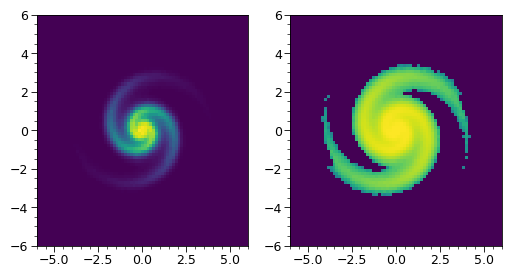

In [5]:
limits = 2 * [(-xmax, xmax)]

fig, axs = plt.subplots(ncols=2, figsize=(6.0, 3.0))
for i, ax in enumerate(axs):
    hist, edges = np.histogramdd(x_true.numpy(), bins=75, range=limits)
    if i:
        hist = np.log10(hist + 1.00e-15)        
    ax.pcolormesh(edges[0], edges[1], hist.T, vmin=(-3.0 if i else 0.0))

## Forward model

In [6]:
phase_advances = torch.linspace(0.0, np.pi, n_meas + 1)[:-1]

transfer_matrices = []
for phase_advance in phase_advances:
    matrix = ment.utils.rotation_matrix(phase_advance)
    matrix = matrix.float()
    transfer_matrices.append(matrix)

transforms = []
for matrix in transfer_matrices:
    transform = ment.sim.LinearTransform(matrix)
    transforms.append(transform)

bin_edges = torch.linspace(-xmax, xmax, n_bins + 1)

diagnostics = []
for transform in transforms:
    diagnostic = ment.Histogram1D(axis=0, edges=bin_edges)
    diagnostics.append([diagnostic])

projections = ment.simulate(x_true, transforms, diagnostics)

## Reconstruction model

In [7]:
samp_grid_shape = (100, 100)
samp_grid_limits = 2 * [(-xmax, xmax)]
sampler = ment.samp.GridSampler(
    limits=samp_grid_limits,
    shape=samp_grid_shape,
    noise=0.0,
)

In [8]:
integration_limits = [(-xmax, xmax)]
integration_limits = [integration_limits for transform in transforms]
integration_size = 200

In [9]:
prior = ment.GaussianPrior(ndim=2, scale=2.0)

In [10]:
model = ment.MENT(
    ndim=ndim,
    transforms=transforms,
    projections=projections,
    prior=prior,
    sampler=sampler,
    nsamp=100_000,
    integration_limits=integration_limits,
    integration_size=integration_size,
    verbose=0,
    mode="reverse",
)

## Training

In [11]:
def plot_model(model):
    figs = []

    # Plot reconstructed vs. true distribution.
    x_pred = model.sample(1_000_000)
    projections_true = ment.unravel(model.projections)
    projections_pred = ment.unravel(ment.simulate(x_pred, model.transforms, model.diagnostics))

    fig, axs = plt.subplots(ncols=2, figsize=(6.0, 3.0))
    for i, ax in enumerate(axs):
        hist, edges = np.histogramdd(x_pred.numpy(), bins=75, range=limits)
        if i:
            hist = np.log10(hist + 1.00e-15)        
        ax.pcolormesh(edges[0], edges[1], hist.T, vmin=(-3.0 if i else 0.0))
    figs.append(fig)

    # Plot simulated vs. measured projections.
    ncols = min(n_meas, 7)
    nrows = int(np.ceil(n_meas / ncols))

    for log in [False, True]:
        fig, axs = plt.subplots(
            ncols=ncols, 
            nrows=nrows, 
            figsize=(1.90 * ncols, 1.25 * nrows),
            sharex=True,
            sharey=True,
        )
        for index in range(len(projections_true)):
            ax = axs[index]
            proj_true = projections_true[index]
            proj_pred = projections_pred[index]
            scale = proj_true.values.max()
            ax.plot(proj_true.coords, proj_true.values / scale, color="lightgray")
            ax.plot(proj_pred.coords, proj_pred.values / scale, color="black", marker=".", lw=0, ms=1.0)
            ax.set_ylim(ax.get_ylim()[0], 1.25)
            ax.set_xlim(-xmax, xmax)
            if log:
                ax.set_yscale("log")
                ax.set_ylim(1.00e-05, 5.0)
        figs.append(fig)

    return figs

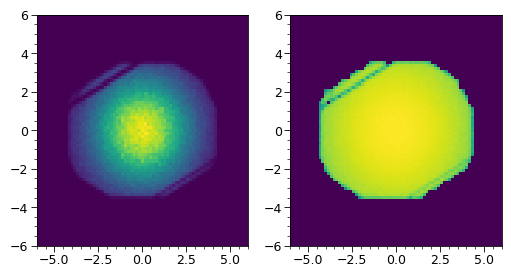

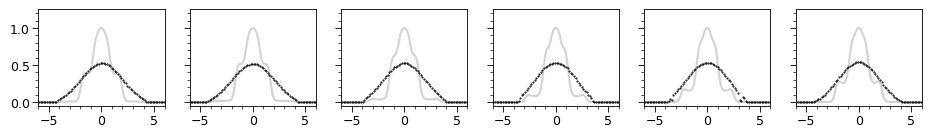

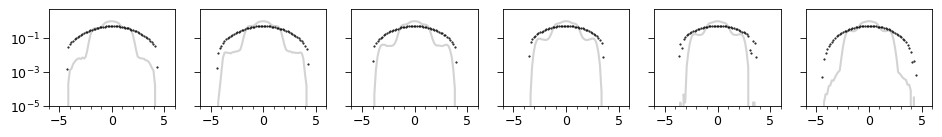

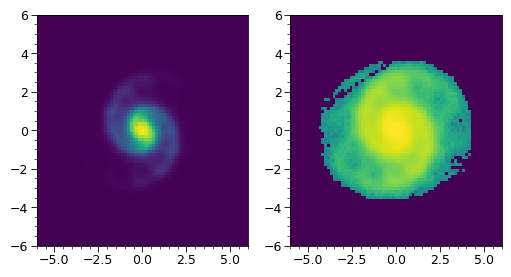

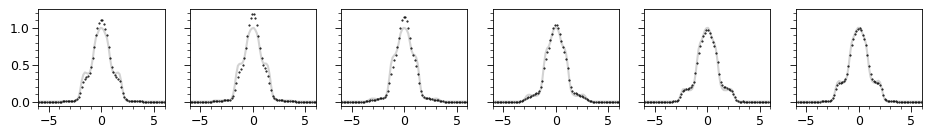

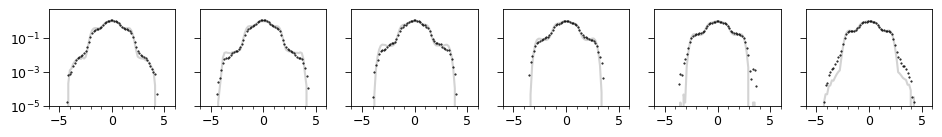

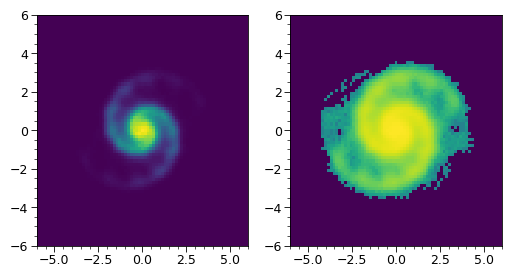

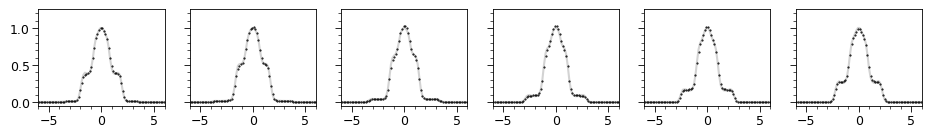

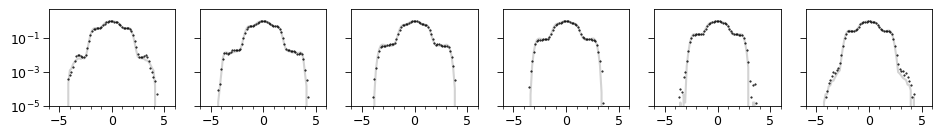

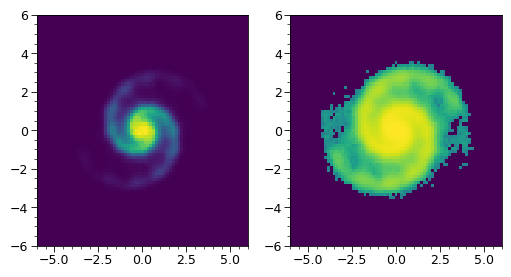

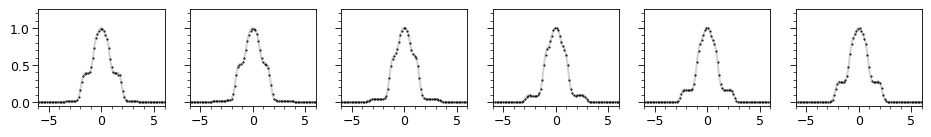

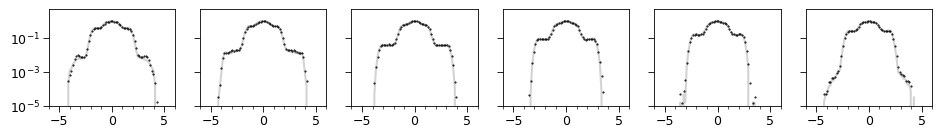

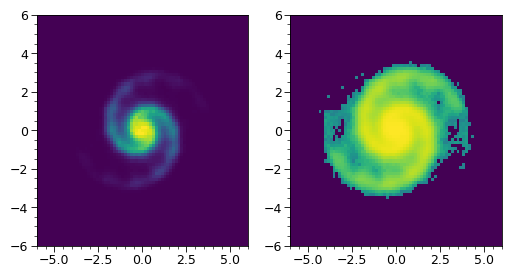

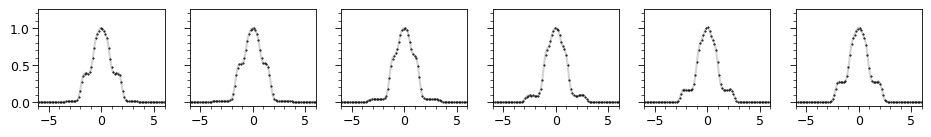

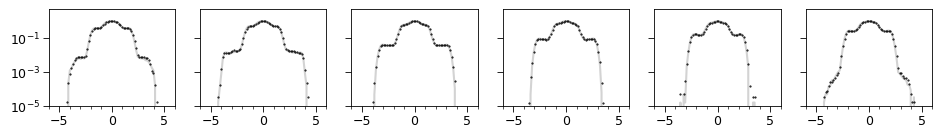

In [12]:
for epoch in range(5):
    if epoch > 0:
        model.gauss_seidel_step(learning_rate=0.75)

    for fig in plot_model(model):
        plt.show()